# AutoEncoders on Handwritten Alphabets

AutoEncoders are a primitive class of Image Generation Deep Learning Models where two neural architectures work together to sample and reconstruct an Input image.  

The main component architectures of an AutoEncoders are :  
- Encoder -> They downsample an image into smaller and smaller neurons to the point that the NxM image is now represented using a small vector, often called as a Latent Vector.
- Bottle Neck -> This is the part where the encoder's mouth becomes significantly small and outputs the compressed image vector to the decoder.
- Decoder -> It is the exact mirror of what the encoders are, they upsample the vector and try to convert it into the original image size and reconstruct the original image.

The Loss function used :  
- MSE Loss -> As we're working with Images only, there is no current need for some advanced Loss function, just simple Mean Squared Error.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")

labels = df.iloc[:, 0]
values = df.iloc[:,1:]

In [3]:
df.shape[0]

372450

We have a lot of handwritten samples in the dataset !

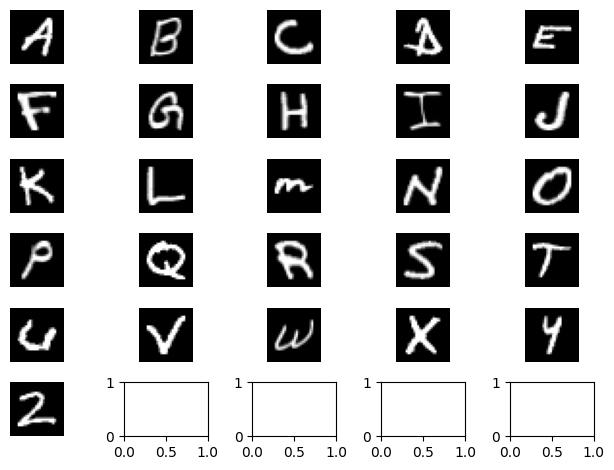

In [4]:
fig, axes = plt.subplots(6, 5)

for i, ax in enumerate(axes.flat):

    rand_idx = np.random.randint(0, df.shape[0])
    alphabet = labels.iloc[rand_idx]

    while alphabet != i:
        rand_idx = np.random.randint(0, df.shape[0])
        alphabet = labels.iloc[rand_idx]

    pixels = values.iloc[rand_idx].to_numpy(dtype=float)
    image = pixels.reshape(28, 28)

    ax.imshow(image, cmap='gray')
    ax.axis('off')

    if i == 25:
        break

plt.tight_layout()
plt.show()

The alphabets look a lot like the MNIST digits

# AutoEncoder using Fully connected Linear Layers

In [8]:
import torch
from tqdm.auto import tqdm
from torch import nn, optim
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
pixel_values = values.to_numpy(dtype=np.float32)
pixel_values = pixel_values / 255.0

tensor_data = torch.tensor(pixel_values)
dataset = TensorDataset(tensor_data, tensor_data)
loader = DataLoader(dataset, batch_size = 64, shuffle=True)

print(f"Dataloader of size {len(loader)} is ready")

Dataloader of size 5820 is ready


In [15]:
class AutoEncoder_v0(nn.Module):
    def __init__(self):
        super(AutoEncoder_v0, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            
            nn.Linear(16, 8)
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.LeakyReLU(0.1),
            
            nn.Linear(16, 32),
            nn.LeakyReLU(0.1),
            
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [25]:
model_v0 = AutoEncoder_v0()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_v0.parameters(), lr=1e-3, weight_decay=1e-8)

model_v0 = model_v0.to(device)

The following are 2 functions for evaluating the Model's outputs.  

eval_model() works by just showing 10 original and reconstructed alphabets  
while, plot_latent_vectors() works by plotting the Latent Vectors of some alphabets derived from the model.

In [26]:
def eval_model(model, loader):
    model.eval()
    
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.to(device)
    
    latent_vector, reconstructed = model(images)

    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(5,1))
    
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

def plot_latent_vectors(model, loader, examples=100):

    model.eval()
    eval_labels = []
    eval_pixels = []

    for alphabet in range(26):
        count = 0
        while count < examples:
            i = np.random.randint(0, df.shape[0])
            label = labels.iloc[i]

            if label == alphabet:
                eval_labels.append(alphabet)
                pixels = values.iloc[i].to_list()
                eval_pixels.append(pixels)
                count += 1

    pixel_values = np.array(eval_pixels, dtype=np.float32) / 255.0
    tensor_data = torch.tensor(pixel_values)

    dataset = TensorDataset(tensor_data, tensor_data)
    eval_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    latent_vectors = []

    with torch.no_grad():
        for images, _ in eval_loader:
            images = images.to(device)
            latent_vector, _ = model(images)
            latent_vectors.append(latent_vector.cpu())

    latent_clean = torch.cat(latent_vectors, dim=0).numpy()

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate='auto',
        init='pca',
        random_state=42
    )

    latent_2d = tsne.fit_transform(latent_clean)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        latent_2d[:, 0],
        latent_2d[:, 1],
        c=eval_labels,
        alpha=0.8,
        cmap='tab10'
    )
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Latent Space")
    plt.show()

Because the Model is not trained yet, the reconstructed images are totally random looking and the plotted latent vectors look absolutely randomly placed

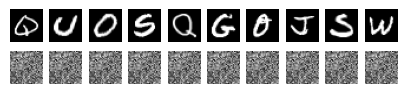

In [27]:
eval_model(model = model_v0, loader = loader)

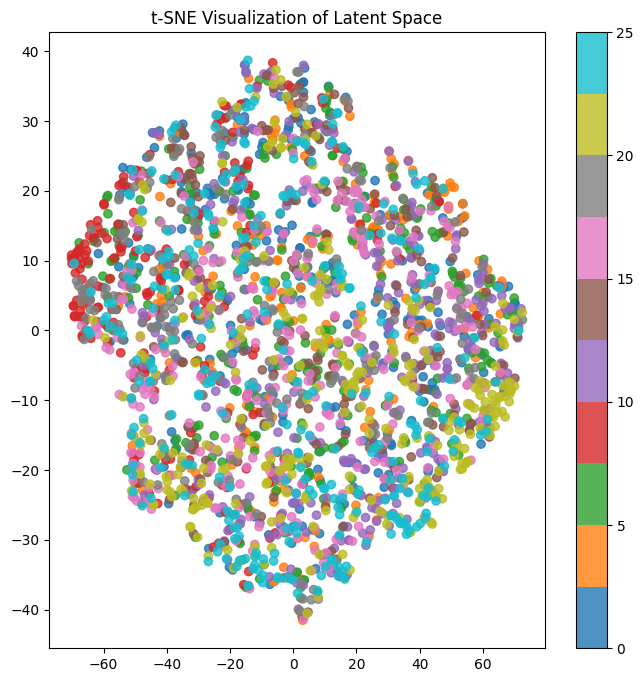

In [28]:
plot_latent_vectors(model = model_v0, loader = loader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 1/20, Loss : 0.018


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 2/20, Loss : 0.019


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 3/20, Loss : 0.020


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 4/20, Loss : 0.024


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 5/20, Loss : 0.018


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 6/20, Loss : 0.018


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 7/20, Loss : 0.015


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 8/20, Loss : 0.019


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 9/20, Loss : 0.017


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 10/20, Loss : 0.019


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 11/20, Loss : 0.018


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 12/20, Loss : 0.017


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 13/20, Loss : 0.013


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 14/20, Loss : 0.019


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 15/20, Loss : 0.018


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 16/20, Loss : 0.014


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 17/20, Loss : 0.017


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 18/20, Loss : 0.017


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 19/20, Loss : 0.017


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 20/20, Loss : 0.018


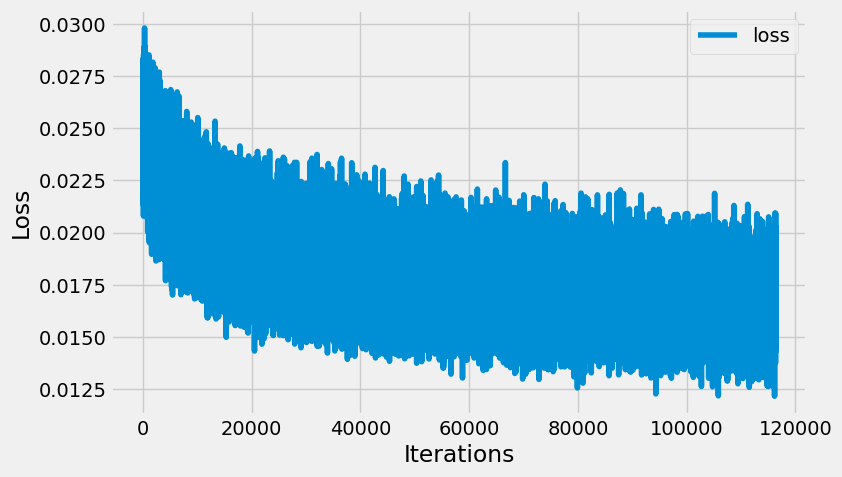

In [32]:
epochs = 20

outputs = []
losses = []


for epoch in tqdm(range(epochs)):
    for images, _ in tqdm(loader):
        images = images.to(device)

        latent_vector, reconstructed = model_v0(images)
        latent_vector = latent_vector.to(device)
        reconstructed = reconstructed.to(device)
        
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss : {loss.item():.3f}")
    # eval_model(model = model_v0, loader = loader)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,5))
plt.plot(losses, label = "loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Voila! The Model reconstructs the original images greatly, with some error being here and there and even the plotted latent vectors look a bit clustered together by the alphabets.

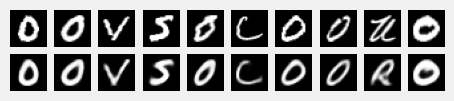

In [33]:
eval_model(model = model_v0, loader = loader)

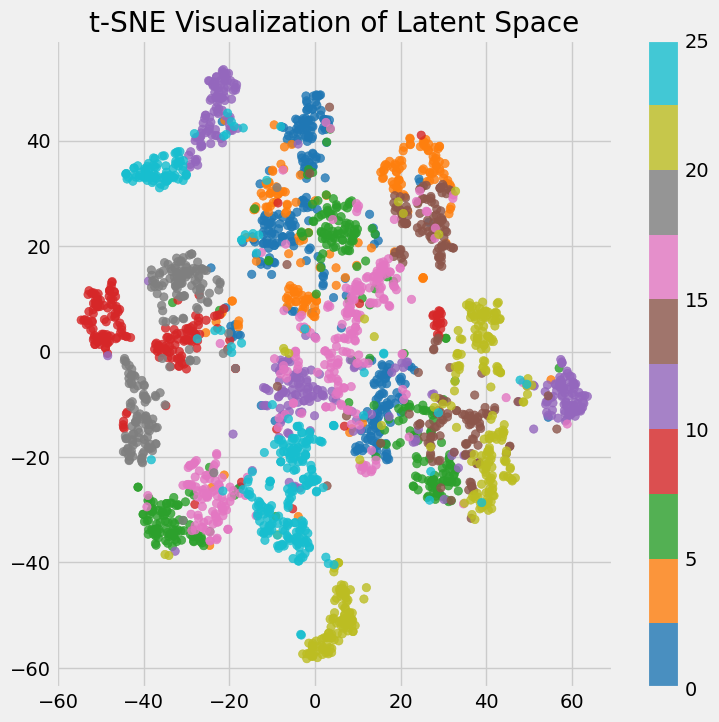

In [34]:
plot_latent_vectors(model = model_v0, loader = loader)

# AutoEncoder using CNN

In [50]:
pixel_values = values.to_numpy(dtype=np.float32)
pixel_values = pixel_values / 255.0

pixel_values = pixel_values.reshape(-1, 1, 28, 28)

tensor_data = torch.tensor(pixel_values)
dataset = TensorDataset(tensor_data, tensor_data)
CNN_loader = DataLoader(dataset, batch_size = 64, shuffle=True)

print(f"Dataloader of size {len(CNN_loader)} is ready")

Dataloader of size 5820 is ready


In [107]:
class AutoEncoder_CNN(nn.Module):
    def __init__(self, latent_dim = 64):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            # nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 32 * 7 * 7)
        
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                              # padding=1, output_padding=1),
            # nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                              padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2,
                              padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)

        encoded = self.fc_enc(x)
        
        x = self.fc_dec(encoded)
        x = x.view(-1, 32, 7, 7)

        decoded = self.decoder(x)
        
        return encoded, decoded

In [128]:
model_CNN = AutoEncoder_CNN(latent_dim = 32)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=1e-3, weight_decay=1e-8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_CNN = model_CNN.to(device)

In [129]:
def eval_model(model, loader):
    model.eval()
    
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.to(device)
    
    latent_vector, reconstructed = model(images)

    # print(latent_vector.shape)
    # print(reconstructed.shape)
    
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(5,1))
    
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

def plot_latent_vectors(model, loader, save = False, plot_name = "default", examples=100):
    model.eval()
    eval_labels = []
    eval_pixels = []

    for alphabet in range(26):
        count = 0
        while count < examples:
            i = np.random.randint(0, df.shape[0])
            label = labels.iloc[i]

            if label == alphabet:
                eval_labels.append(alphabet)
                pixels = values.iloc[i].to_list()
                eval_pixels.append(pixels)
                count += 1

    pixel_values = np.array(eval_pixels, dtype=np.float32) / 255.0
    pixel_values = pixel_values.reshape(-1, 1, 28, 28)

    tensor_data = torch.tensor(pixel_values)

    dataset = TensorDataset(tensor_data, tensor_data)
    eval_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    latent_vectors = []

    with torch.no_grad():
        for images, _ in eval_loader:
            images = images.to(device)
            latent_vector, _ = model(images)

            latent_vector = latent_vector.view(latent_vector.size(0), -1)

            latent_vectors.append(latent_vector.cpu())

    latent_clean = torch.cat(latent_vectors, dim=0).numpy()

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate='auto',
        init='pca',
        random_state=42
    )

    latent_2d = tsne.fit_transform(latent_clean)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        latent_2d[:, 0],
        latent_2d[:, 1],
        c=eval_labels,
        alpha=0.8,
        cmap='tab10'
    )

    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Latent Space")

    if save:
        plt.savefig(plot_name, dpi=300, bbox_inches='tight')
    
    plt.show()

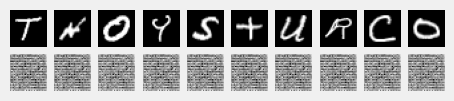

In [130]:
eval_model(model = model_CNN, loader = CNN_loader)

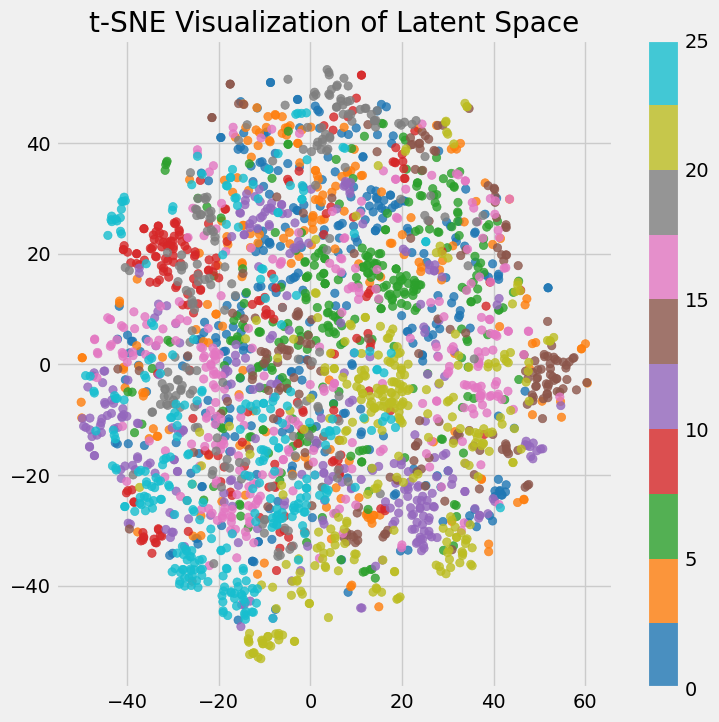

In [131]:
plot_latent_vectors(model = model_CNN, loader = CNN_loader, save = True, plot_name = "plot_0")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 1/10, Loss : 0.006


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 2/10, Loss : 0.005


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 3/10, Loss : 0.005


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 4/10, Loss : 0.005


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 5/10, Loss : 0.004


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 6/10, Loss : 0.004


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 7/10, Loss : 0.005


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 8/10, Loss : 0.004


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 9/10, Loss : 0.004


  0%|          | 0/5820 [00:00<?, ?it/s]

Epoch 10/10, Loss : 0.004


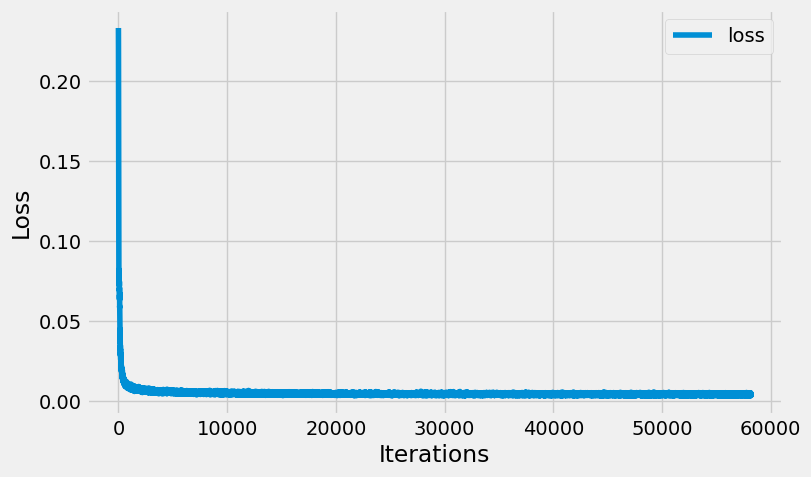

In [132]:
epochs = 10

outputs = []
losses = []


for epoch in tqdm(range(epochs)):
    for images, _ in tqdm(CNN_loader):
        images = images.to(device)

        latent_vector, reconstructed = model_CNN(images)
        latent_vector = latent_vector.to(device)
        reconstructed = reconstructed.to(device)
        
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss : {loss.item():.3f}")

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,5))
plt.plot(losses, label = "loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

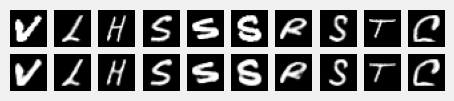

In [133]:
eval_model(model = model_CNN, loader = CNN_loader)

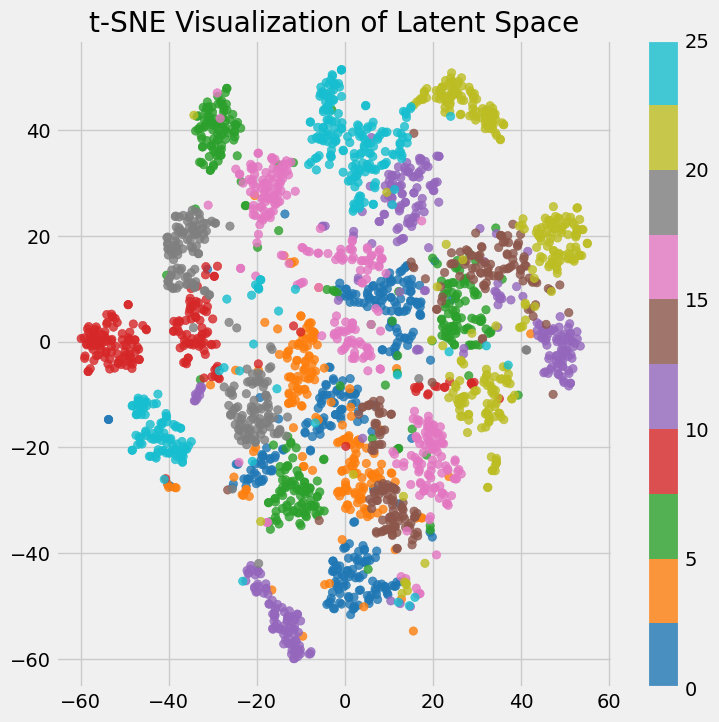

In [134]:
plot_latent_vectors(model = model_CNN, loader = CNN_loader)

# Variational AutoEncoders

In [26]:
pixel_values = values.to_numpy(dtype=np.float32)
pixel_values = pixel_values / 255.0

pixel_values = pixel_values.reshape(-1, 1, 28, 28)

batch_size = 64

tensor_data = torch.tensor(pixel_values)
dataset = TensorDataset(tensor_data, tensor_data)
VAE_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

print(f"Dataloader of size {len(Var_loader)} is ready")

Dataloader of size 5820 is ready


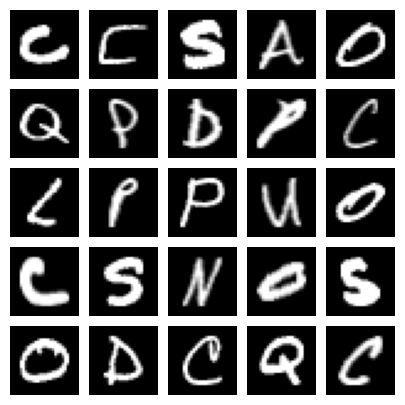

In [27]:
dataiter = iter(VAE_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [55]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.var_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, var = self.mean_layer(x), self.var_layer(x)
        return mean, var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, var = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var

In [96]:
model_VAE = VAE().to(device)
optimizer = optim.Adam(model_VAE.parameters(), lr=1e-3)

In [97]:
def loss_function(x, x_hat, mean, var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())

    return reproduction_loss + KLD

def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model_VAE.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28,28)
    plt.imshow(digit, cmap = 'gray')
    plt.axis('off')
    plt.show()

def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=5):
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, y in enumerate(grid_y):
        for j, x in enumerate(grid_x):
            z_sample = torch.tensor([[x,y]], dtype=torch.float).to(device)
            x_decoded = model_VAE.decode(z_sample)
            digit = x_decoded[0].detach().cpu().numpy()
            digit = digit.reshape(digit_size, digit_size)
            figure[i*digit_size : (i+1)*digit_size, j*digit_size : (j+1)*digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualisation")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x, rotation=90, fontsize=8)
    plt.yticks(pixel_range, sample_range_y, fontsize=8)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

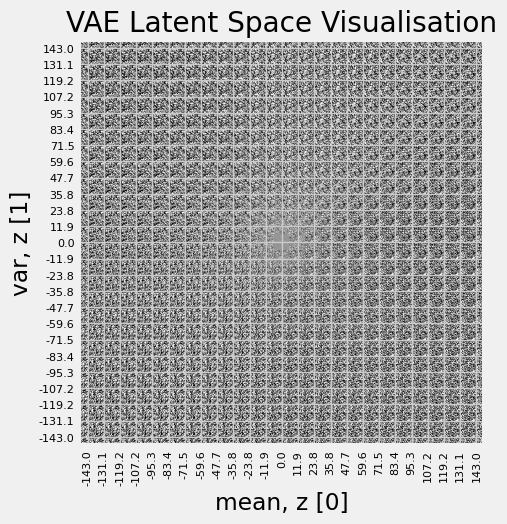

In [98]:
plot_latent_space(model_VAE, scale = 143)

In [ ]:
losses = []

In [113]:
epochs = 30

model_VAE.train()

new_losses = []

for epoch in tqdm(range(epochs)):
    running_loss = 0
    for batch_idx, (images, _) in enumerate(VAE_loader):
        images = images.view(images.size(0), -1).to(device)

        images_hat, mean, var = model_VAE(images)
        
        loss = loss_function(images, images_hat, mean, var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss : {running_loss/len(VAE_loader.dataset)}")
    # plot_latent_space(model_VAE, scale = 8)
    new_losses.append(running_loss/(batch_idx*batch_size))



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss : 156.30595819934933
Epoch 2/30, Loss : 156.27741171738657
Epoch 3/30, Loss : 156.207832737878
Epoch 4/30, Loss : 156.27554809291726
Epoch 5/30, Loss : 156.19818110940855
Epoch 6/30, Loss : 156.2489476146127
Epoch 7/30, Loss : 156.10475758071553
Epoch 8/30, Loss : 156.11564439490618
Epoch 9/30, Loss : 156.06055947369194
Epoch 10/30, Loss : 156.0244644992197
Epoch 11/30, Loss : 156.0604856933397
Epoch 12/30, Loss : 156.0223533727262
Epoch 13/30, Loss : 156.00715441958442
Epoch 14/30, Loss : 156.11552125023073
Epoch 15/30, Loss : 155.9818866469073
Epoch 16/30, Loss : 156.0125549675292
Epoch 17/30, Loss : 155.9707920604905
Epoch 18/30, Loss : 155.8492294110367
Epoch 19/30, Loss : 155.99003131319012
Epoch 20/30, Loss : 155.9896632347358
Epoch 21/30, Loss : 155.94425496763407
Epoch 22/30, Loss : 155.8410029253612
Epoch 23/30, Loss : 155.80087767522278
Epoch 24/30, Loss : 155.8324829032735
Epoch 25/30, Loss : 155.82633584415694
Epoch 26/30, Loss : 155.7189966485644
Epoch 27/

In [114]:
losses += new_losses

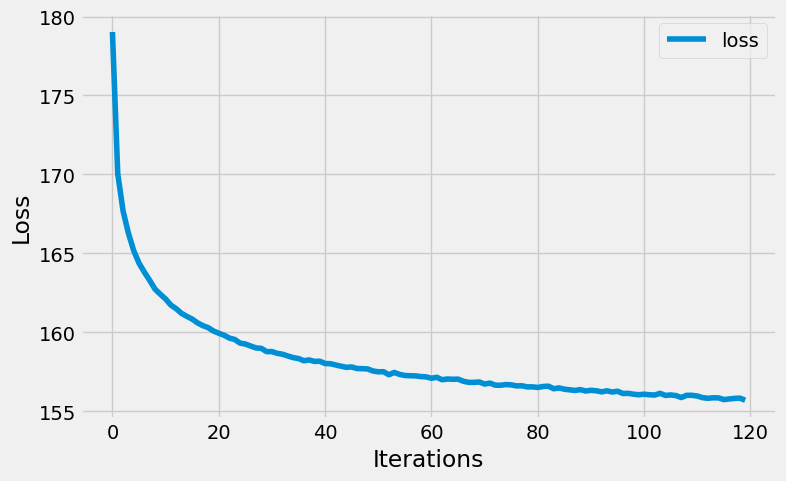

In [115]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,5))
plt.plot(losses, label = "loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

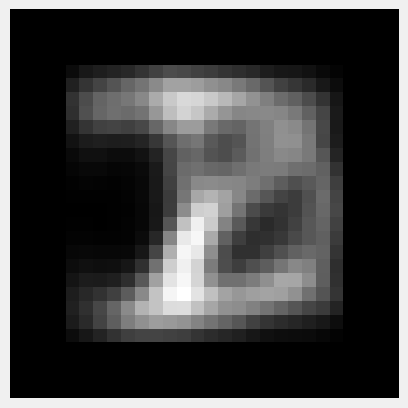

In [111]:
generate_digit(1.0, 0.0)

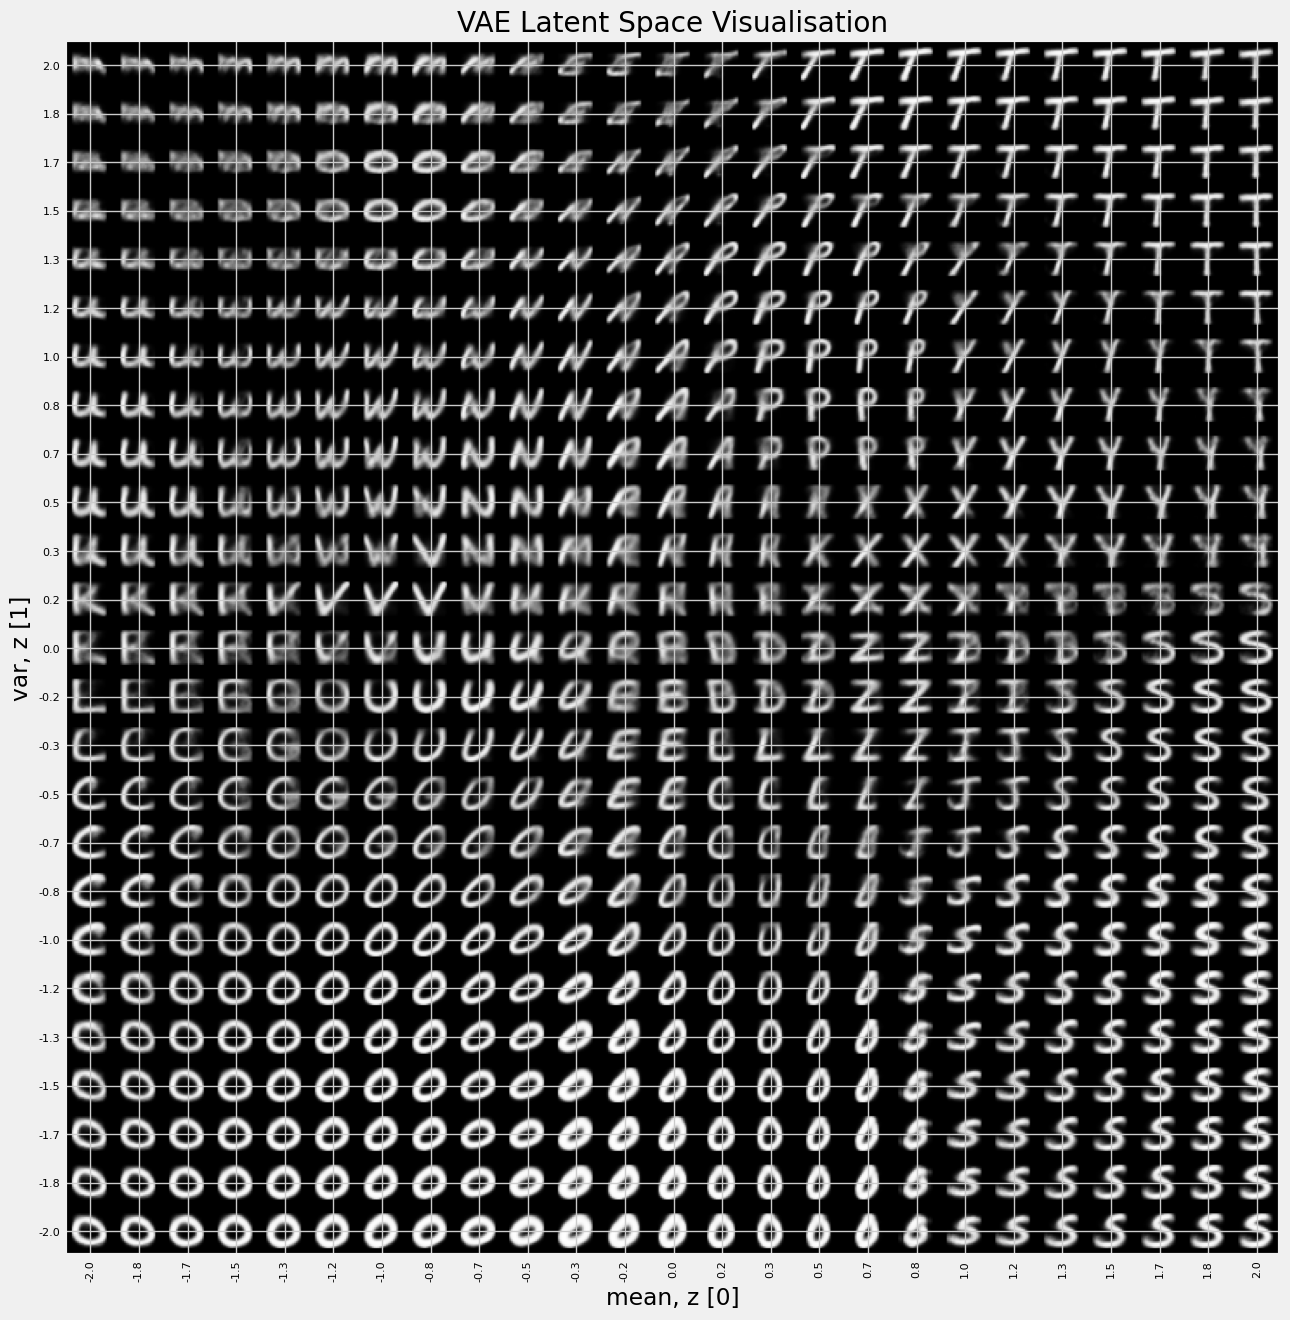

In [118]:
plot_latent_space(model_VAE, scale = 2, figsize=15)